# MONTE CARLO SIMULATIONS

Monte Carlo methods rely on random sampling to obtain numerical results. One such application is to draw random samples from a probability distribution representing uncertain potential future states of the world where variables or assumptions can take on a range of values.

It is helpful to do the Monte Carlo simulation on a simplified DCF(discounted cash flow) valuation model instead of the more common examples you see showing valuation of options or other derivatives, since for this we don’t need any math beyond the basics of calculating the financial statements and discounting cash flows, allowing us to focus on the Python concepts and tools. Please note though that this basic tutorial model is meant to illustrate the key concepts, and is not useful as-is for any practical purposes. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
years = ['2018A', '2019B', '2020P', '2021P', '2022P', '2023P']
sales = pd.Series(index=years)
sales['2018A'] = 31.0  
sales

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


2018A    31.0
2019B     NaN
2020P     NaN
2021P     NaN
2022P     NaN
2023P     NaN
dtype: float64

With the first three lines we have created a data structure with an index consisting of years (each marked to show if it is Actual, Budget or Projected), a starting value (in millions of euros), and empty (NaN, “Not a Number”) cells for the projections. <br>The fourth line prints a representation of the data - in general, typing the name of a variable or other objects in the interactive interpreter will usually give you a sensible representation of it.

<br>

Next, we declare a variable to represent the projected annual sales growth. At this stage, it is a point estimate, the same figure as in our original DCF model.<br>Using this variable, we create a loop that calculates the sales in each year of the projections based on the previous year and the growth rate:

In [6]:
growth_rate=0.1
for year in range (1,6):
    sales[year]=sales[year-1]*(1+growth_rate)
sales

2018A    31.00000
2019B    34.10000
2020P    37.51000
2021P    41.26100
2022P    45.38710
2023P    49.92581
dtype: float64

Using the same approach, we continue through the financial statements, declaring variables as we need them and performing the necessary calculations to eventually arrive at free cash flow.<br> __NOTE: EBITDA= earnings before interest, taxes, depreciation, and amortization (used as an indicator of the overall profitability of a business).__

In [7]:
ebitda_margin = 0.14
depr_percent = 0.032
ebitda = sales * ebitda_margin
depreciation = sales * depr_percent
ebit = ebitda - depreciation
nwc_percent = 0.24
nwc = sales * nwc_percent
change_in_nwc = nwc.shift(1) - nwc 
capex_percent = depr_percent
capex = -(sales * capex_percent)
tax_rate = 0.25
tax_payment = -ebit * tax_rate
tax_payment = tax_payment.apply(lambda x: min(x, 0))
free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
free_cash_flow

2018A         NaN
2019B    2.018100
2020P    2.219910
2021P    2.441901
2022P    2.686091
2023P    2.954700
dtype: float64

# Performing the DCF Valuation

Having arrived at projected cash flows, we can now calculate a simple terminal value and discount all cash flows back to the present to get the DCF result. The following code introduces indexing and slicing, which allows us to access one or more elements in a data structure, such as the Pandas Series object.

Simple indexing accesses elements by their position, starting with zero, meaning that free_cash_flow[1] would give us the second element. [-1] is shorthand for accessing the last element (the last year’s cash flow is used to calculate the terminal value), and using a colon gives us a slice, meaning that [1:] gives us all elements except the first one, since we don’t want to include the historical year 2018A in our DCF valuation.

In [8]:
cost_of_capital = 0.12
terminal_growth = 0.02
terminal_value = ((free_cash_flow[-1] * (1 + terminal_growth)) / 
                 (cost_of_capital - terminal_growth))
discount_factors = [(1 / (1 + cost_of_capital)) ** i for i in range (1,6)]
dcf_value = (sum(free_cash_flow[1:] * discount_factors) +
            terminal_value * discount_factors[-1])
dcf_value

25.79438401113792

# Exporting the data

Before moving on to the actual Monte Carlo simulation, this might be a good time to mention the exporting capabilities available in the Pandas package. If you have a Pandas DataFrame object, you can write that to an Excel file with one line using the to_excel method. There is similar functionality to export to more than a dozen other formats and destinations as well.

In [11]:
output = pd.DataFrame([sales, ebit, free_cash_flow], index=['Sales', 'EBIT', 'Free Cash Flow']).round(1)
output

,2018A,2019B,2020P,2021P,2022P,2023P
Sales,31.0,34.1,37.5,41.3,45.4,49.9
EBIT,3.3,3.7,4.1,4.5,4.9,5.4
Free Cash Flow,NaN,2.0,2.2,2.4,2.7,3.0


In [12]:
output.to_excel('Python DCF Model Output.xlsx')

# Creating Probability Distributions for Our Monte Carlo Simulation

Our first step is to decide how many iterations we want to run in the simulation. Using 1,000 as a starting point strikes a balance between getting enough data points to get sensible output plots, versus having the simulation finish within a sensible time frame. Next, we generate the actual distributions. For the sake of simplicity, I generated three normal distributions here, but the NumPy library has a large number of distributions to choose from, and there are other places to look as well, including the Python standard library. After deciding which distribution to use, we need to specify the parameters required to describe their shape, such as mean and standard deviation, and the number of desired outcomes.

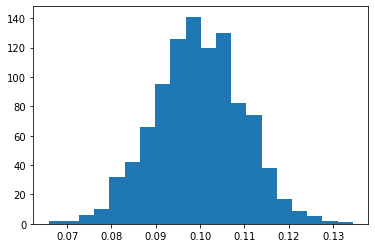

In [19]:
iterations = 1000
sales_growth_dist = np.random.normal(loc=0.1, scale=0.01, size=iterations)
ebitda_margin_dist = np.random.normal(loc=0.14, scale=0.02, size=iterations)
nwc_percent_dist = np.random.normal(loc=0.24, scale=0.01, size=iterations)
plt.hist(sales_growth_dist, bins=20)
plt.show()

Here you could argue that EBITDA should not be a separate random variable independent from sales but instead correlated with sales to some degree. I would agree with this, and add that it should be driven by a solid understanding of the dynamics of the cost structure (variable, semi-variable and fixed costs) and the key cost drivers (some of which may have their own probability distributions, such as for example input commodities prices), but I leave those complexities aside here for the sake of space and clarity.

The less data you have to inform your choice of distribution and parameters, the more you will have to rely on the outcome of your various due diligence workstreams, combined with experience, to form a consensus view on ranges of likely scenarios. In this example, with cash flow projections, there will be a large subjective component, which means that visualizing the probability distributions becomes important. Here, we can get a basic visualization, showing the sales growth distribution, with only two short lines of code. This way we can quickly view any distribution to eyeball one that best reflects the team’s collective view.

Now we have all the building blocks we need to run the simulation, but they are not in a convenient format for running the simulation. Here is the same code we have worked with thus far but all gathered in one cell and rearranged into a function for convenience:

In [20]:
def run_mcs():
    
    # Create probability distributions
    sales_growth_dist = np.random.normal(loc=0.1, scale=0.01, size=iterations)
    ebitda_margin_dist = np.random.normal(loc=0.14, scale=0.02, size=iterations)
    nwc_percent_dist = np.random.normal(loc=0.24, scale=0.01, size=iterations)
    
    # Calculate DCF value for each set of random inputs
    output_distribution = []
    for i in range(iterations):
        for year in range(1, 6):
            sales[year] = sales[year - 1] * (1 + sales_growth_dist[0])
        ebitda = sales * ebitda_margin_dist[i]
        depreciation = (sales * depr_percent)
        ebit = ebitda - depreciation
        nwc = sales * nwc_percent_dist[i]
        change_in_nwc = nwc.shift(1) - nwc 
        capex = -(sales * capex_percent)
        tax_payment = -ebit * tax_rate
        tax_payment = tax_payment.apply(lambda x: min(x, 0))
        free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
        
        # DCF valuation
        terminal_value = (free_cash_flow[-1] * 1.02) / (cost_of_capital - 0.02)
        free_cash_flow[-1] += terminal_value
        discount_factors = [(1 / (1 + cost_of_capital)) ** i for i in range (1,6)]
        dcf_value = sum(free_cash_flow[1:] * discount_factors )
        output_distribution.append(dcf_value)
    
    return output_distribution

__'timeit' module provides a simple way to time small bits of Python code. It has both a Command-Line Interface as well as a callable one. It avoids a number of common traps for measuring execution times.__

In [21]:
import timeit

2.36 s ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


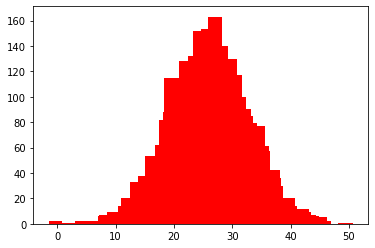

In [24]:
%timeit plt.hist(run_mcs(), bins=20, color='r')
plt.show()

# Refining the Prototype 

In [25]:
# Key inputs from DCF model
years = 5
starting_sales = 31.0
capex_percent = depr_percent = 0.032
sales_growth = 0.1
ebitda_margin = 0.14
nwc_percent = 0.24
tax_rate = 0.25
# DCF assumptions
r = 0.12
g = 0.02
# For MCS model
iterations = 1000
sales_std_dev = 0.01
ebitda_std_dev = 0.02
nwc_std_dev = 0.01

In [26]:
def run_mcs():
    
    # Generate probability distributions
    sales_growth_dist = np.random.normal(loc=sales_growth, 
                                         scale=sales_std_dev, 
                                         size=(years, iterations))
    ebitda_margin_dist = np.random.normal(loc=ebitda_margin, 
                                          scale=ebitda_std_dev, 
                                          size=(years, iterations))
    nwc_percent_dist = np.random.normal(loc=nwc_percent, 
                                        scale=nwc_std_dev, 
                                        size=(years, iterations))
    
    # Calculate free cash flow
    sales_growth_dist += 1
    for i in range(1, len(sales_growth_dist)):
        sales_growth_dist[i] *= sales_growth_dist[i-1]
    sales = sales_growth_dist * starting_sales
    ebitda = sales * ebitda_margin_dist
    ebit = ebitda - (sales * depr_percent)
    tax = -(ebit * tax_rate)
    np.clip(tax, a_min=None, a_max=0)
    nwc = nwc_percent_dist * sales
    starting_nwc = starting_sales * nwc_percent
    prev_year_nwc = np.roll(nwc, 1, axis=0)
    prev_year_nwc[0] = starting_nwc
    delta_nwc = prev_year_nwc - nwc
    capex = -(sales * capex_percent)
    free_cash_flow = ebitda + tax + delta_nwc + capex
    # Discount cash flows to get DCF value
    terminal_value = free_cash_flow[-1] * (1 + g) / (r - g)
    discount_rates = [(1 / (1 + r)) ** i for i in range (1,6)]
    dcf_value = sum((free_cash_flow.T * discount_rates).T) 
    dcf_value += terminal_value * discount_rates[-1]
        
    return dcf_value

The main difference you will notice between this version and the previous one is the absence of the for i in range(iterations) loop. Using NumPy’s array operation, this version runs in 18 milliseconds compared to the 1.35 seconds for the prototype version - roughly 75x faster.

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 35.3 ms


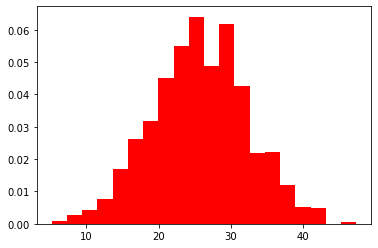

In [27]:
%time plt.hist(run_mcs(), bins=20, density=True, color="r")
plt.show()

I’m sure that further optimization is possible, since I put together both the prototype and refined version in a short time solely for the purpose of this tutorial.

# Thank You